In [1]:
import copy
import os, sys
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.interpolate import interp1d

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

import sys
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt


sys.path.append('../')

from BGS import BGS
from HST import HST
from COSMOS import COSMOS

from FileEmcee import FileEmcee
from EmceeRun import EmceeRun

from Plotter import Plotter
from PlotterHst import PlotterHst
from PlotterCOSMOS import PlotterCOSMOS

from VMaxDensity import VmaxDensity
from VMaxDensityHst import VmaxDensityHst

from ZSchechterModel import ZSchechterModel
from NoZSchechterModel import NoZSchechterModel

from Fileh5 import Fileh5

In [2]:
def mass_completeness_limit_bgs(z):
    x_values = np.array([0.00247985, 0.00483082, 0.00656047, 0.0090045 , 0.01228954,
       0.01468146, 0.01739703, 0.01982065, 0.02223816, 0.02478942,
       0.02718216, 0.0297723 , 0.03214576, 0.03475644, 0.03725439,
       0.03969578, 0.04231814, 0.04471862, 0.04726608, 0.04971804,
       0.05217666, 0.05485575, 0.05714361, 0.05983116, 0.0622433 ,
       0.06477037, 0.06729212, 0.0696601 , 0.07221736, 0.07470074,
       0.07726848, 0.07970581, 0.08235858, 0.08472435, 0.08723007,
       0.08963203, 0.09228077, 0.09477242, 0.09729331, 0.099802  ,
       0.10227854, 0.10469317, 0.10715788, 0.10972896, 0.11231016,
       0.11474048, 0.11718   , 0.11978621, 0.12227634, 0.12479607,
       0.12729936, 0.12974797, 0.13225808, 0.13471149, 0.13727515,
       0.13970204, 0.14227686, 0.14457675, 0.14727102, 0.14978783,
       0.15221812, 0.15465339, 0.15732456, 0.15978838, 0.1621385 ,
       0.16474496, 0.16723761, 0.16974835, 0.17225687, 0.17476975,
       0.17729319, 0.17983345, 0.18223385, 0.18479195, 0.18722791,
       0.1897866 , 0.19230325, 0.19474093, 0.1972761 , 0.19978505,
       0.20218162, 0.20478321, 0.20722114, 0.20978526, 0.2123442 ,
       0.21464457, 0.21721705, 0.21974108, 0.22214348, 0.22478031,
       0.22732483, 0.22962546, 0.23230192, 0.23478154, 0.23726658,
       0.23973219, 0.24223737, 0.24477807, 0.24733377, 0.24963889,
       0.25230877, 0.2547754 , 0.25726801, 0.25967258, 0.26232256,
       0.26477256, 0.26728391, 0.26966953, 0.27217287, 0.27460324,
       0.27722196, 0.27959586, 0.28229134, 0.2848037 , 0.28725984,
       0.28985701, 0.2923195 , 0.29462396, 0.29705607])
    
    y_values = np.array([ 6.19233606,  6.83089859,  7.19541283,  7.49541767,  7.73446394,
        7.97573148,  8.1206893 ,  8.28289916,  8.38297483,  8.4857448 ,
        8.5662122 ,  8.65428108,  8.68919015,  8.79760012,  8.85287516,
        8.91898337,  9.00431108,  9.04462424,  9.09902614,  9.12211824,
        9.19599217,  9.27656627,  9.28617265,  9.35747078,  9.38232742,
        9.42622197,  9.48121354,  9.49533128,  9.55465837,  9.58076478,
        9.61429673,  9.64659735,  9.68782778,  9.7159304 ,  9.75738293,
        9.79091068,  9.81607921,  9.82226304,  9.85758522,  9.87375352,
        9.8906075 ,  9.90740924,  9.9281017 ,  9.97121565,  9.98271625,
        9.99167673, 10.01813817, 10.04717844, 10.07974563, 10.09122367,
       10.09460286, 10.1539076 , 10.14871284, 10.16391119, 10.18545648,
       10.20465581, 10.23759639, 10.24537951, 10.25409408, 10.27692096,
       10.30349627, 10.3382326 , 10.33327252, 10.35523964, 10.35273232,
       10.37603491, 10.41671427, 10.41610546, 10.43212978, 10.47420657,
       10.46000597, 10.47431897, 10.48711649, 10.51094253, 10.51319548,
       10.52246781, 10.55200452, 10.56919663, 10.56833965, 10.58467215,
       10.61157816, 10.60453819, 10.63106187, 10.63100251, 10.63726941,
       10.65600309, 10.66358378, 10.67474176, 10.69383125, 10.69470662,
       10.71030144, 10.72679253, 10.73585073, 10.75277773, 10.76502898,
       10.78441052, 10.78582517, 10.8062511 , 10.80029193, 10.80723995,
       10.83403985, 10.87394328, 10.86794826, 10.87265313, 10.89667329,
       10.88012479, 10.87382357, 10.92230226, 10.91554066, 10.91910413,
       10.93963065, 10.95808569, 10.95081633, 10.97014478, 10.99860375,
       11.01836781, 11.03326512, 11.03070553, 11.03879802])
    
    f = interp1d(x_values, y_values, fill_value='extrapolate')
    return f(z)

In [3]:
def smf_double_schechter_sty(x, z,  a0, a1, a2, alpha1, alpha2, a7, a8, a9):
    logM = a0*z**2 + a1*z + a2
#     alpha1 = -.28
#     alpha2 = -1.48
    log_phi2_phi1 = a7*z**2 + a8*z + a9
    
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha2+1)*(x - logM))
    term2 = 10 ** ((alpha1+1)*(x - logM) + log_phi2_phi1)
    return term0 * (term1 + term2)


def smf_single_schechter_sty(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


def plot_zschechter_double(x, z0, norm, best_params, **plot_params):
    a0, a1, a2, alpha1, alpha2, a7, a8, a9 = best_params
    zschechter = smf_double_schechter_sty(x, z0,  a0, a1, a2, alpha1, alpha2, a7, a8, a9)
    plt.plot(x, norm * zschechter, **plot_params)

    plt.yscale('log')
    plt.ylim(1e-5, 4e-2)
    plt.xlim(7, 13)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)



def plot_zschechter_single(x, z0, norm, best_params, **plot_params):
    a0, a1, a2, a3 = best_params
    zschechter = smf_single_schechter_sty(x, z0, a0, a1, a2, a3)
    plt.plot(x, norm * zschechter, **plot_params)

    plt.yscale('log')
    plt.ylim(1e-5, 4e-2)
    plt.xlim(7, 13)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)


def normalisation_single(z0, zmin, zmax, z, best_params):
    a0, a1, a2, a3 = best_params
    # v_zmin = Planck13.comoving_volume(zmin).value # (Mpc/h)^3
    # v_zmax = Planck13.comoving_volume(zmax).value # (Mpc/h)^3

    vzmin_bgs = Planck13.comoving_volume(zmin).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3
    vzmax_bgs = Planck13.comoving_volume(zmax).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))
    
    m_max = 13
    m_min = 6.
    nbin = 40
    bin_size = (m_max - m_min) / nbin
    # x_median_bgs = x
    # z_bgs, z_cosmos, z_hst = z

    # x_bgs_bin = x_median_bgs[(z_bgs > zmin) & (z_bgs < zmax)]

    z_bgs_bin = z[(z > zmin) & (z < zmax)]

    I_bgs = [integrate.quad(smf_single_schechter_sty, mass_completeness_limit_bgs(z_bgs_bin)[i], 13., 
                            args=(z0, a0, a1, a2, a3))[0] for i in range(z_bgs_bin.shape[0])]

    
    N_bgs = bin_size / (vzmax_bgs - vzmin_bgs) * np.sum((1.) / np.array(I_bgs))
    
    return N_bgs


def normalisation(z0, zmin, zmax, x, z, best_params):
    a0, a1, a2, alpha1, alpha2, a7, a8, a9 = best_params
    # v_zmin = Planck13.comoving_volume(zmin).value # (Mpc/h)^3
    # v_zmax = Planck13.comoving_volume(zmax).value # (Mpc/h)^3

    vzmin_bgs = Planck13.comoving_volume(zmin).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3
    vzmax_bgs = Planck13.comoving_volume(zmax).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))
    
    m_max = 13
    m_min = 6.
    nbin = 40
    bin_size = (m_max - m_min) / nbin
    # x_median_bgs = x
    # z_bgs, z_cosmos, z_hst = z

    x_bgs_bin = x_median_bgs[(z_bgs > zmin) & (z_bgs < zmax)]

    z_bgs_bin = z_bgs[(z_bgs > zmin) & (z_bgs < zmax)]

    I_bgs = [integrate.quad(smf_double_schechter_sty, mass_completeness_limit_bgs(z_bgs_bin)[i], 13., 
                            args=(z0, a0, a1, a2, alpha1, alpha2, a7, a8, a9))[0] for i in range(z_bgs_bin.shape[0])]

    
    N_bgs = bin_size / (vzmax_bgs - vzmin_bgs) * np.sum((1.) / np.array(I_bgs))
    
    return N_bgs

In [4]:
bgs = BGS('BGS_ANY_full.provabgs.lite.hdf5')

In [5]:
emcee_file = Fileh5(folder='emcee_runs', info_file='_single_')
emcee_run = EmceeRun(emcee_file)

emcee_file_double = Fileh5(folder='emcee_runs', info_file='BGS_train')
emcee_run_double = EmceeRun(emcee_file_double)

In [6]:
emcee_run.set_best_params(discard=230)
emcee_run_double.set_best_params(discard=230)

In [7]:
inds = np.random.randint(len(emcee_run.flat_samples), size=200)
a = []

for ind in inds:
    a.append(emcee_run.flat_samples[ind])
    
    

In [8]:
# np.save('./a.npy', np.array(a))

In [9]:
# zmins = np.array([0.01 + 0.04 * i for i in range(7)])
# zmaxs = np.array([0.05 + 0.04 * i for i in range(7)])

# for zmin, zmax, z0 in zip(zmins, zmaxs, zmins + (zmaxs - zmins)/2):
#     z, _, _, w_spec, _ = bgs.select_galaxies(zmin, zmax)
#     n_best = normalisation_single(z0, zmin, zmax, z, emcee_run.get_best_params())
#     np.save(f'n_best_{round(zmin,2)}_{round(zmax,2)}', n_best)


In [10]:
zmin, zmax = 0.01, 0.05
z0 = zmin + (zmax - zmin)/2.

In [11]:
z, _, _, w_spec, _ = bgs.select_galaxies(zmin, zmax)

In [12]:
# best_params = np.load('./a_single_schechter.npy')
# n = []
# for best_i in tqdm(best_params, unit='iteration'):
#     n.append(normalisation_single(z0, zmin, zmax, z, best_i))
    
# np.save(f'./n_{zmin}_{zmax}.npy', np.array(n))

In [13]:
plotter = Plotter(bgs, emcee_run)

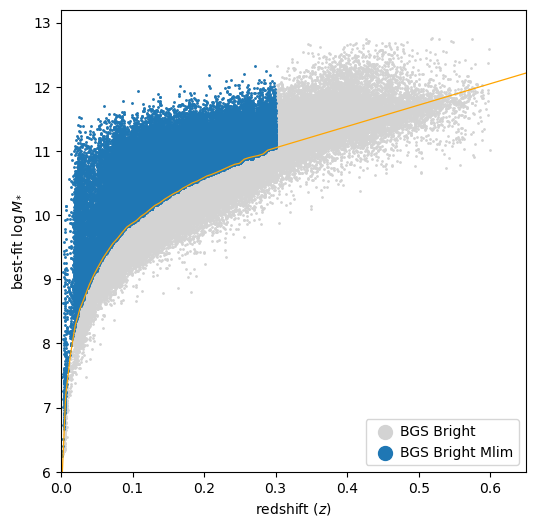

In [14]:
plt.figure(figsize=(6,6))
plotter.plot_selected_data(0., 0.3)
# plt.xlim(0., 0.05)

In [15]:
# plotter.plot_emcee_samples()

In [16]:
# emcee_run.set_best_params(discard=230)
# emcee_run_double.set_best_params(discard=230)

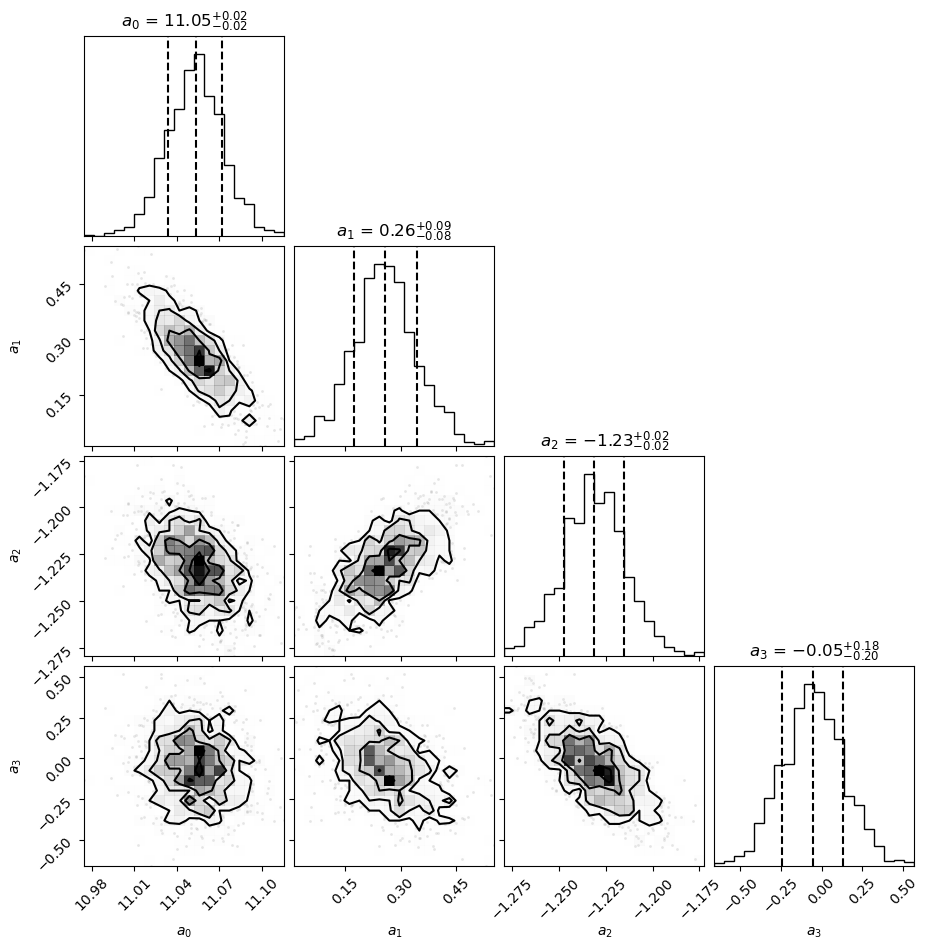

In [17]:
plotter.plot_emcee_corner(emcee_run.flat_samples, emcee_run.labels4)

In [18]:
vmax_hist = VmaxDensity(bgs.file, is_bgs_bright=True)

/Users/federico/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/PhD_project/bgs_psmf/paper/../VMaxDensity.py:19: RuntimeWarning: divide by zero encountered in divide
  _w = self.w_spec / (self.vmax.clip(v_zmin, v_zmax) - v_zmin)


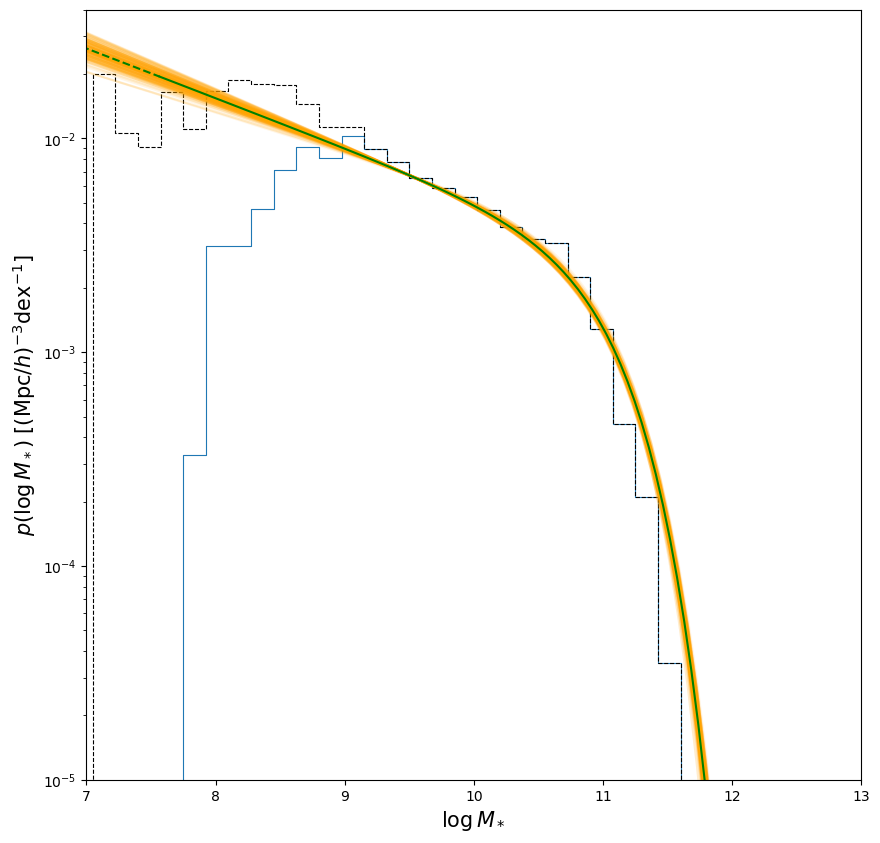

In [19]:
best_params = emcee_run.get_best_params()

plt.figure(figsize=(10,10))

n = np.load('./n_0.01_0.05.npy')
a = np.load('./a_single_schechter.npy')
n_best_01_05 = np.load('./n_best_0.01_0.05.npy')

h, b, _h, _b = vmax_hist.histogram_norm(zmin, zmax)
Plotter.plot_vmax_hist(h, b, _h, b, **{'label':f'{round(zmin,2)} < z < {round(zmax,2)}'})

mlim = mass_completeness_limit_bgs(zmin)

for n_i, a_i in zip(n,a):
    plot_zschechter_single(np.linspace(6, 13, 100), z0, n_i, a_i, color='orange', alpha=0.1)

plot_zschechter_single(np.linspace(6, mlim, 100), z0, n_best_01_05, best_params,
                           color='green', linestyle='--')

plot_zschechter_single(np.linspace(mlim, 13, 100), z0, n_best_01_05, best_params,
                           color='green')


In [ ]:
zmins = np.array([0.0 + 0.03 * i for i in range(10)])
zmaxs = np.array([0.03 + 0.03 * i for i in range(10)])
z0s = zmins + (zmaxs - zmins)/2

In [ ]:
best_params = emcee_run.get_best_params()
best_params_double = emcee_run_double.get_best_params()
plt.figure(figsize=(10,30))
for p, zmin, zmax, z0_i in zip(range(0,14),zmins, zmaxs, z0s):
    plt.subplot(7, 2, p+1)

    

    h, b, _h, _b = vmax_hist.histogram_norm(zmin, zmax)
    Plotter.plot_vmax_hist(h, b, _h, b, **{'label':f'{round(zmin,2)} < z < {round(zmax,2)}'})

    z_bgs, _, x_median_bgs, w_spec_bgs, _ = bgs.select_galaxies(zmin, zmax)
    norm_single = normalisation_single(z0_i, zmin, zmax, x_median_bgs, z_bgs, best_params)
    norm_double = normalisation(z0_i, zmin, zmax, x_median_bgs, z_bgs, best_params_double)

    mlim = mass_completeness_limit_bgs(zmin)

    plot_zschechter_single(np.linspace(6, mlim, 100), z0_i, norm_single, best_params,
                           color='orange', linestyle='--')
    # plot_zschechter_double(np.linspace(6, mlim, 100), z0_i, norm_double, best_params_double,
                           # color='green', linestyle='--')
    
    plot_zschechter_single(np.linspace(mlim, 13, 100), z0_i, norm_single, best_params, label=f'z = {round(z0_i,2)}', color='orange')
    # plot_zschechter_double(np.linspace(mlim, 13, 100), z0_i, norm_double, best_params_double, label='double Schechter', color='green')

    

    plt.legend(loc='best')
plt.tight_layout()
plt.savefig('../paper/BGS_fit.png')
    